In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import lightgbm as lgb

In [34]:
from sklearn.model_selection import KFold

## 读入数据

In [2]:
train_df = pd.read_csv('../input/train.csv')

In [3]:
test_df = pd.read_csv('../input/test.csv')

In [29]:
train_df.shape[0], test_df.shape[0]

(90615, 60411)

## EDA

In [8]:
train_df.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [9]:
train_df.Sex.value_counts()

Sex
I    33093
M    31027
F    26495
Name: count, dtype: int64

In [10]:
train_df.Rings.value_counts()

Rings
9     17465
8     14499
10    12464
7      9008
11     8407
6      5411
12     4719
13     4074
5      2862
14     2507
15     2072
16     1439
4      1402
17     1175
18      848
19      639
20      507
3       386
21      255
23      180
22      108
27       41
2        29
24       29
1        25
29       24
25       22
26       18
Name: count, dtype: int64

## 建模

### lightgbm

In [30]:
Sex2code = {'I': 0, 'M': 1, 'F': 2}

In [31]:
train_df['Sex_code'] = train_df.Sex.map(Sex2code)

In [44]:
test_df['Sex_code'] = test_df.Sex.map(Sex2code)

In [32]:
train_cols = [c for c in train_df.columns if c not in {'Rings', 'Sex'}]

In [40]:
target_col = 'Rings'

In [42]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'lambda_l1': 1,
    'metric': 'l2',
    'early_stopping_rounds': 400,
}

In [36]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [46]:
oof = np.zeros(train_df.shape[0])
pred = np.zeros(test_df.shape[0])
feature_importance_df = []

for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index)):
    print(f'fold={i}', '- ' * 20)
    trn_data = lgb.Dataset(train_df.loc[trn_idx, train_cols], label=train_df.loc[trn_idx, target_col], categorical_feature=['Sex_code'])
    val_data = lgb.Dataset(train_df.loc[val_idx, train_cols], label=train_df.loc[val_idx, target_col], categorical_feature=['Sex_code'])

    model = lgb.train(params, trn_data, 10000, valid_sets=val_data, callbacks=[lgb.log_evaluation(100)])

    oof[val_idx] = model.predict(train_df.loc[val_idx, train_cols], num_iteration=model.best_iteration)
    pred += model.predict(test_df[train_cols], num_iteration=model.best_iteration)

    importance_df = pd.DataFrame()
    importance_df['feature'] = train_cols
    importance_df['importance'] = model.feature_importance()
    importance_df['fold'] = i
    feature_importance_df.append(importance_df)

feature_importance_df = pd.concat(feature_importance_df, axis=0, ignore_index=True)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.697111
Training until validation scores don't improve for 400 rounds
[100]	valid_0's l2: 3.51479
[200]	valid_0's l2: 3.48367
[300]	valid_0's l2: 3.46954
[400]	valid_0's l2: 3.46569
[500]	valid_0's l2: 3.4662
[600]	valid_0's l2: 3.47167
[700]	valid_0's l2: 3.47084
[800]	valid_0's l2: 3.47714
Early stopping, best iteration is:
[427]	valid_0's l2: 3.46325
fold=1 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names,

In [48]:
train_df['oof'] = oof

In [49]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_code,oof
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,2,10.016144
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,2,10.863612
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0,4.054129
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,1,10.487924
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0,8.481230


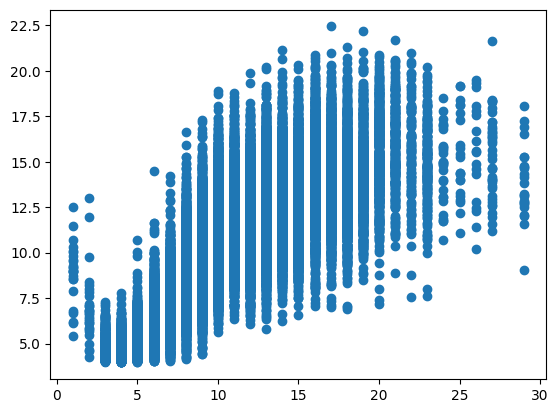

In [50]:
plt.scatter(train_df.Rings, train_df.oof)

In [26]:
train_data = lgb.Dataset(train_df[train_cols], label=train_df['Rings'], categorical_feature=['Sex_code'])

In [27]:
lgb_cv = lgb.cv(
    params, 
    train_data, 
    10000, 
    nfold=4, 
    stratified=False,
    callbacks=[lgb.log_evaluation(50)],
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 67959, number of used features: 9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 67959, number of used features: 9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

In [28]:
lgb.cv?

Signature:
lgb.cv(
    params: Dict[str, Any],
    train_set: lightgbm.basic.Dataset,
    num_boost_round: int = 100,
    folds: Union[Iterable[Tuple[numpy.ndarray, numpy.ndarray]], sklearn.model_selection._split.BaseCrossValidator, NoneType] = None,
    nfold: int = 5,
    stratified: bool = True,
    shuffle: bool = True,
    metrics: Union[str, List[str], NoneType] = None,
    feval: Union[Callable[[numpy.ndarray, lightgbm.basic.Dataset], Tuple[str, float, bool]], Callable[[numpy.ndarray, lightgbm.basic.Dataset], List[Tuple[str, float, bool]]], List[Union[Callable[[numpy.ndarray, lightgbm.basic.Dataset], Tuple[str, float, bool]], Callable[[numpy.ndarray, lightgbm.basic.Dataset], List[Tuple[str, float, bool]]]]], NoneType] = None,
    init_model: Union[str, pathlib.Path, lightgbm.basic.Booster, NoneType] = None,
    feature_name: Union[List[str], ForwardRef("Literal['auto']")] = 'auto',
    categorical_feature: Union[List[str], List[int], ForwardRef("Literal['auto']")] = 'auto',
    

In [24]:
lgb_cv

{'valid l2-mean': [8.992646894243647,
  8.026746016700486,
  7.302455777876854,
  6.6470727500251865,
  6.11006886506589,
  5.730305014728824,
  5.352718983337658,
  5.043853923258472,
  4.8090055503195295,
  4.611892330941165,
  4.451106375743487,
  4.309786390937407,
  4.177757962802707,
  4.069338233903398,
  3.9871011516215797,
  3.9187370599581426,
  3.8624636036551303,
  3.8045720009053214,
  3.756773813984862,
  3.7175369065868797,
  3.681552603405449,
  3.6517534960823097,
  3.6293197102845265,
  3.6065274902568087,
  3.5869229977387613,
  3.5702214368777065,
  3.558782400865381,
  3.5462944047922136,
  3.536129532208845,
  3.5250483032696844,
  3.5158576030758826,
  3.507398711638273,
  3.500366069067079,
  3.494985732209085,
  3.490552099388813,
  3.486584010569048,
  3.4816149330473,
  3.477184175817315,
  3.473625987419077,
  3.4701307029404633,
  3.4665386036449295,
  3.464777348726948,
  3.4608744306031047,
  3.4580070633330138,
  3.455288688680137,
  3.453313112953638,
 

In [25]:
len(lgb_cv['valid l2-mean'])

371

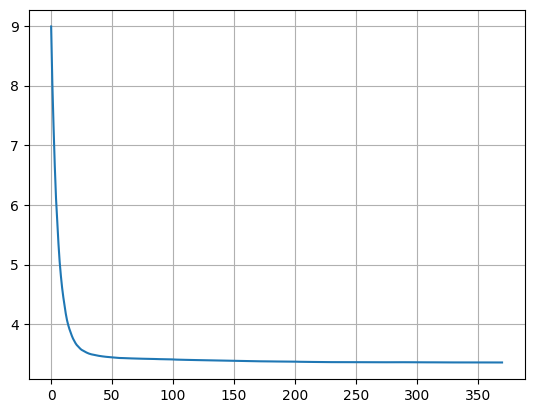

In [20]:
plt.plot(lgb_cv['valid l2-mean'][:1000])
plt.grid()

In [54]:
model = lgb.train(params, train_data, 400)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 9
[LightGBM] [Info] Start training from score 9.696794


In [55]:
test_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [56]:
test_df['Sex_code'] = test_df.Sex.map(Sex2code)

In [59]:
preds = model.predict(test_df[train_cols])

In [61]:
test_df['Rings'] = preds

## 提交

In [62]:
sub_df = pd.read_csv('../input/sample_submission.csv')

In [63]:
sub_df.head()

,id,Rings
0,90615,10
1,90616,10
2,90617,10
3,90618,10
4,90619,10


In [64]:
(sub_df['id'] == test_df['id']).all()

True

In [65]:
cols = ['id', 'Rings']
test_df[cols].to_csv('simple_lgb_iter400.csv', index=False, header=True)

In [66]:
!head simple_lgb_iter400.csv

id,Rings
90615,9.5980866867818
90616,9.373612869946278
90617,10.025133025264868
90618,10.005288110050207
90619,7.55387503516864
90620,9.446224644208044
90621,10.704996517741126
90622,6.310706393807703
90623,8.047817413929062


In [67]:
!head ../input/sample_submission.csv

id,Rings
90615,10
90616,10
90617,10
90618,10
90619,10
90620,10
90621,10
90622,10
90623,10


In [68]:
lgb.cv?

Signature:
lgb.cv(
    params: Dict[str, Any],
    train_set: lightgbm.basic.Dataset,
    num_boost_round: int = 100,
    folds: Union[Iterable[Tuple[numpy.ndarray, numpy.ndarray]], sklearn.model_selection._split.BaseCrossValidator, NoneType] = None,
    nfold: int = 5,
    stratified: bool = True,
    shuffle: bool = True,
    metrics: Union[str, List[str], NoneType] = None,
    feval: Union[Callable[[numpy.ndarray, lightgbm.basic.Dataset], Tuple[str, float, bool]], Callable[[numpy.ndarray, lightgbm.basic.Dataset], List[Tuple[str, float, bool]]], List[Union[Callable[[numpy.ndarray, lightgbm.basic.Dataset], Tuple[str, float, bool]], Callable[[numpy.ndarray, lightgbm.basic.Dataset], List[Tuple[str, float, bool]]]]], NoneType] = None,
    init_model: Union[str, pathlib.Path, lightgbm.basic.Booster, NoneType] = None,
    feature_name: Union[List[str], ForwardRef("Literal['auto']")] = 'auto',
    categorical_feature: Union[List[str], List[int], ForwardRef("Literal['auto']")] = 'auto',
    

In [70]:
lgb.__version__

'4.3.0'

In [71]:
lgb.train?

Signature:
lgb.train(
    params: Dict[str, Any],
    train_set: lightgbm.basic.Dataset,
    num_boost_round: int = 100,
    valid_sets: Union[List[lightgbm.basic.Dataset], NoneType] = None,
    valid_names: Union[List[str], NoneType] = None,
    feval: Union[Callable[[numpy.ndarray, lightgbm.basic.Dataset], Tuple[str, float, bool]], Callable[[numpy.ndarray, lightgbm.basic.Dataset], List[Tuple[str, float, bool]]], List[Union[Callable[[numpy.ndarray, lightgbm.basic.Dataset], Tuple[str, float, bool]], Callable[[numpy.ndarray, lightgbm.basic.Dataset], List[Tuple[str, float, bool]]]]], NoneType] = None,
    init_model: Union[str, pathlib.Path, lightgbm.basic.Booster, NoneType] = None,
    feature_name: Union[List[str], ForwardRef("Literal['auto']")] = 'auto',
    categorical_feature: Union[List[str], List[int], ForwardRef("Literal['auto']")] = 'auto',
    keep_training_booster: bool = False,
    callbacks: Union[List[Callable], NoneType] = None,
) -> lightgbm.basic.Booster
Docstring:
Perfo